# Задание

Выберите ряд (файл в приложении к заданию), на котором происходит аномалия. Примените к нему все 4 способа поиска аномалий.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
series = pd.read_csv("numbers-on-unemployment-benefits1.csv")
series = series.dropna()

In [3]:
series.columns = ['month', 'num']

In [4]:
series.head()

,month,num
0,1956-01,4742.0
1,1956-02,6128.0
2,1956-03,6494.0
3,1956-04,5379.0
4,1956-05,6011.0


In [7]:
len(series)

439

In [8]:
series = series[:439]

In [10]:
series.num = series.num.fillna(0)
series = series.num

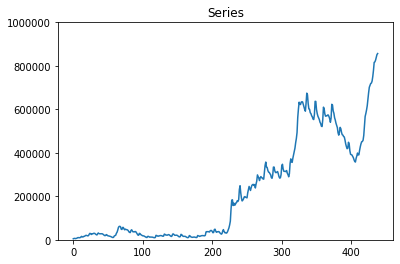

In [11]:
plt.plot(series)
plt.ylim(0,1000000)
plt.title("Series")
plt.show()

# Mean detector

In [15]:
class Detector:
    def __init__(self):
        raise NotImplementedError
    def update(self):
        raise NotImplementedError
    def _detect(self):
        raise NotImplementedError

In [16]:
class MeanDetector(Detector):
    def __init__(self,thresh):
        self.thresh = thresh
        self.sum = 0
        self.count = 0
        self.mean = 0
    
    def update(self,value):
        self.count += 1
        self.sum += value
        
        return self.count - 1 if self._detect(value) else -1
    
    def _detect(self,value):
        mean = self.sum/self.count
        return True if np.abs(value-mean) > mean*self.thresh else False

Точка изменения найдена при индексе 226


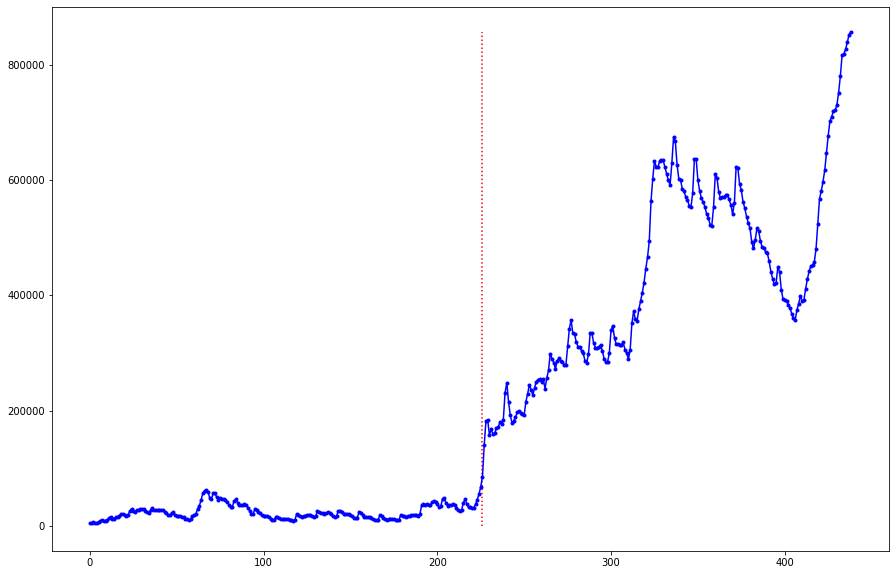

In [20]:
THRESH = 1.95

md = MeanDetector(THRESH)
for each in series:
    idx = md.update(each)
    if idx > 0:
        print(f'Точка изменения найдена при индексе {idx}')
        plt.figure(figsize=(15,10))
        plt.plot(series,'b.-')
        plt.vlines(x = idx,ymin=0, ymax=np.max(series), colors='r', linestyles='dotted')
        _ = plt.show()
        break

# Z-Score

In [21]:
from collections import deque

class ZScoreDetector(Detector):
    def __init__(self, window_size, threshold):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.mean = 0.0  
        self.s = 0.0
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self,value):
        self.window.append(value)
        
        old_mean = self.mean
        new_mean = old_mean + (value - old_mean) / (self.k + 1)
        
        s = self.s + (value - new_mean) * (value - old_mean)
        std = np.sqrt(s / (self.k+1))
        
        window_mean = np.mean(self.window)
        window_std = np.std(self.window)
        
        std_diff = (std - window_std) / std        
        SE = std / np.sqrt(self.window_size)
        mean_diff = (new_mean - window_mean) / new_mean
        self.z_score = (window_mean - new_mean) / SE
        
        self.mean = new_mean
        self.s = s        
        self.k += 1
        
        return self.k-1 if self._detect(value) else -1
    
    def _detect(self,value):
        return np.abs(self.z_score) > self.threshold

Точка изменения найдена при индексе 227


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


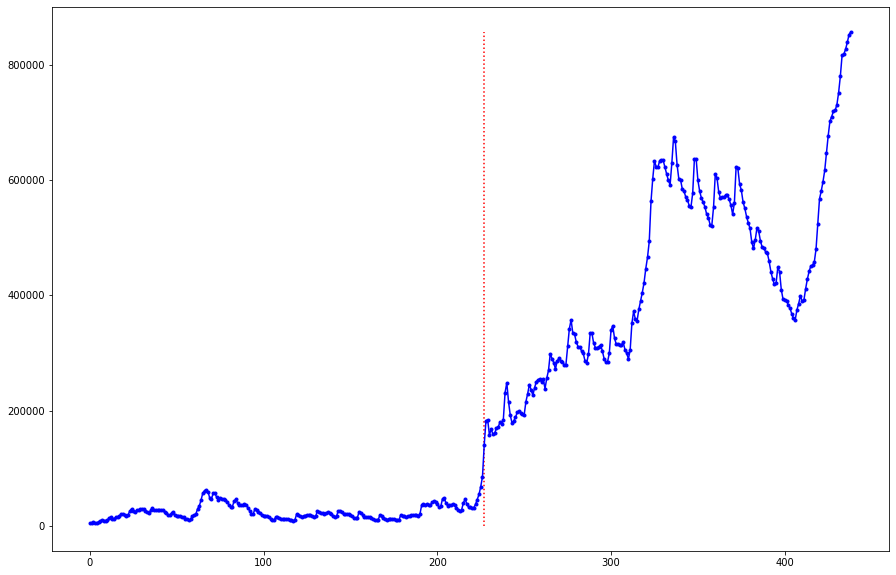

In [23]:
THRESH = 7
WINDOW_SIZE = 5
zd = ZScoreDetector(WINDOW_SIZE,THRESH)
sub_series = series
for each in sub_series:
    idx = zd.update(each)
    if idx > 0:
        print(f'Точка изменения найдена при индексе {idx}')
        plt.figure(figsize=(15,10))
        plt.plot(sub_series,'b.-')
        plt.vlines(x = idx,ymin=0, ymax=np.max(series), colors='r', linestyles='dotted')
        _ = plt.show()
        break
if idx == -1:
    print ('Точки изменений не найдены')

# CumSum

In [24]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

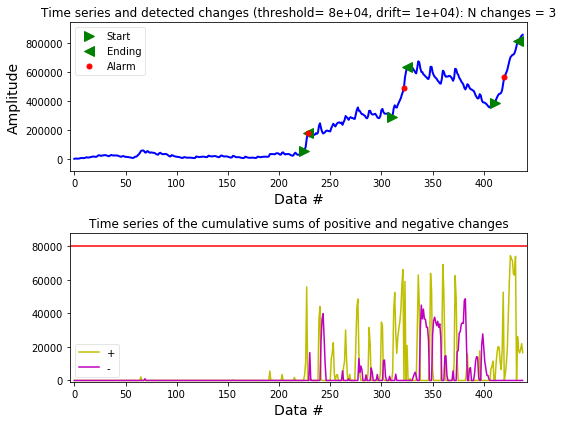

In [25]:
ta, tai, taf, amp = detect_cusum(series, 80000, 10000, True, True)

# One Class SVM

In [26]:
from sklearn.svm import OneClassSVM

In [27]:
clf = OneClassSVM(nu=0.5, kernel="rbf", gamma='auto')

In [33]:
series_n = series.values
series_n = series_n.reshape((len(series_n), 1))

In [38]:
series_train = series_n[:200]
series_test = series_n[200:270]

clf.fit(series_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [39]:
pred_trn = clf.predict(series_train)
pred_tst = clf.predict(series_test)
pred = np.concatenate((pred_trn,pred_tst)).astype(object)
pred [ pred == 1 ] = 'OK'
pred [ pred == -1 ] = 'Change'

ser = np.concatenate((series_train,series_test)).reshape(-1)

In [40]:
import seaborn as sns

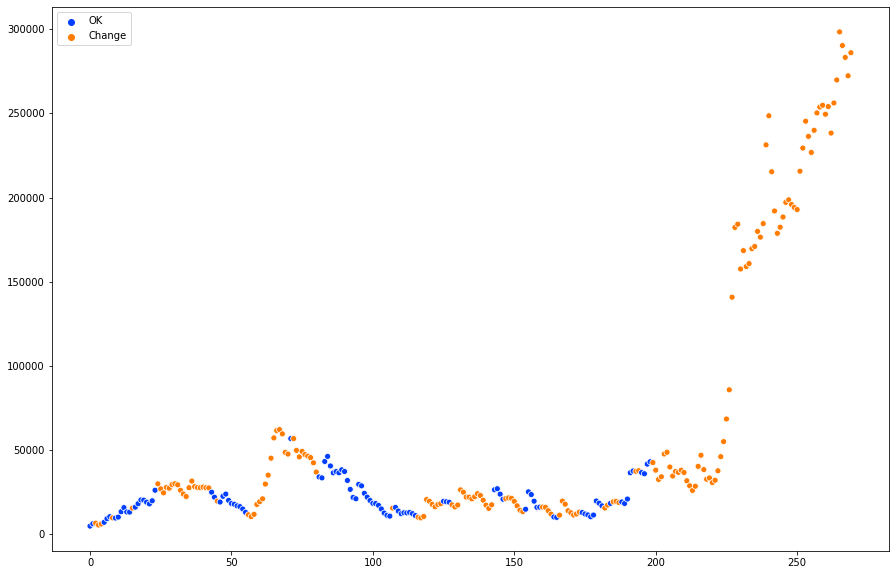

In [41]:
with sns.color_palette("bright"):
    plt.figure(figsize=(15,10))
    _= sns.scatterplot(range(len(pred)),ser,hue=pred)

In [42]:
clf = OneClassSVM(nu=0.15, kernel="rbf", gamma='auto')
series_train = series_n[:380]
series_test = series_n[380:]

clf.fit(series_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.15, shrinking=True, tol=0.001, verbose=False)

In [43]:
pred_trn = clf.predict(series_train)
pred_tst = clf.predict(series_test)
pred = np.concatenate((pred_trn,pred_tst)).astype(object)
pred [ pred == 1 ] = 'OK'
pred [ pred == -1 ] = 'Change'

ser = np.concatenate((series_train,series_test)).reshape(-1)

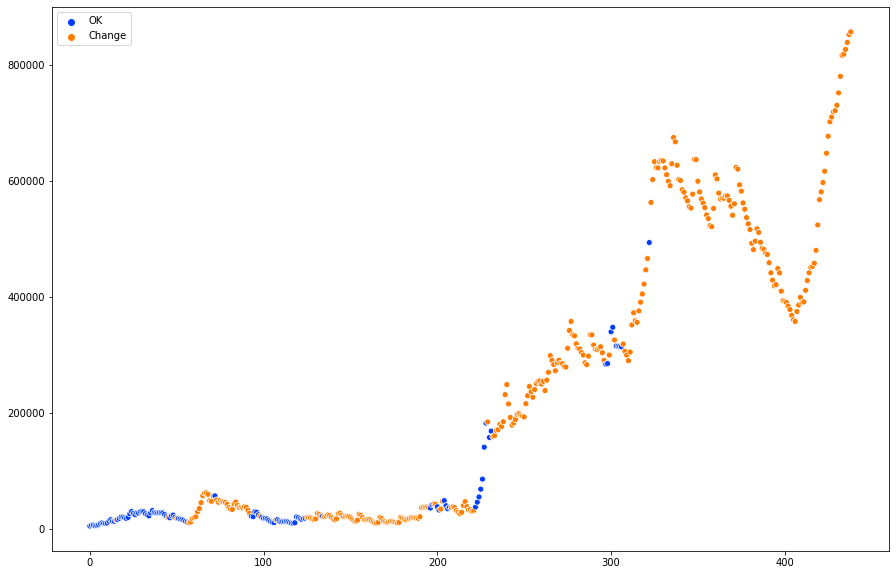

In [44]:
with sns.color_palette("bright"):
    plt.figure(figsize=(15,10))
    _= sns.scatterplot(range(len(pred)),ser,hue=pred)

In [45]:
ser_len = series_n.shape[0]
step = 20
pred_cnt = 5

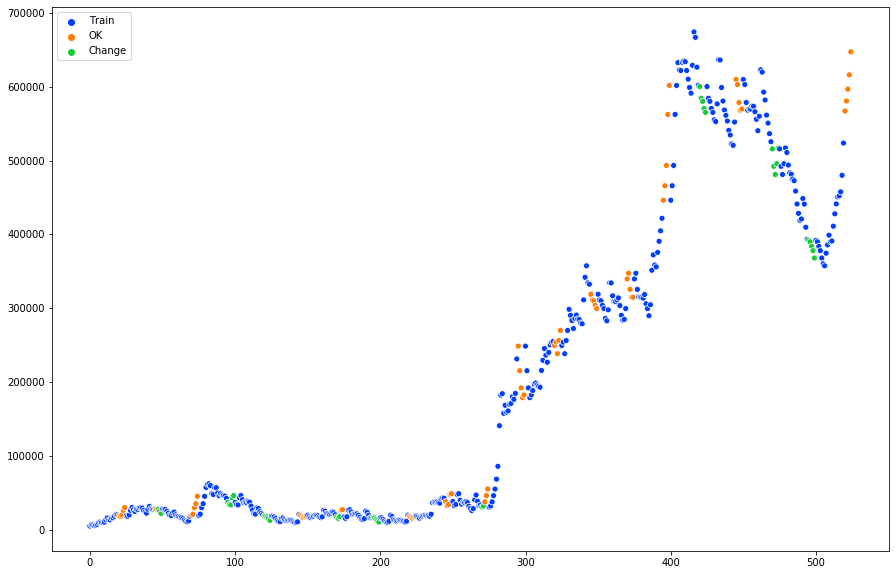

In [47]:
clf = OneClassSVM(nu=0.5, kernel="poly",degree=3, gamma='auto')

global_ser = np.array([])
global_pred = np.array([])
for i in range(0,ser_len-step,step):
    series_train = series_n[i:i+step]
    series_test = series_n[i+step:i+step+pred_cnt]
    
    clf.fit(series_train)
    
    #pred_trn = clf.predict(series_train)
    pred_tst = clf.predict(series_test)
    pred = np.concatenate((['Train']*(step),pred_tst)).astype(object)
   
    pred [ pred == '1' ] = 'OK'
    pred [ pred == '-1' ] = 'Change'
    global_pred = np.concatenate((global_pred,pred))
    ser = np.concatenate((series_train,series_test)).reshape(-1)
    global_ser = np.concatenate((global_ser,ser))

with sns.color_palette("bright"):
    plt.figure(figsize=(15,10))
    _ = sns.scatterplot(range(len(global_pred)),global_ser,hue=global_pred)